[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/machinelearnear/custom-segmentation-model-with-icevision-openimages/blob/main/1_inference_test.ipynb)

# Train Custom Image Segmentation Model with `IceVision` and `OpenImages`
- www.machinelearne.ar

### Training parameters

In [ ]:
epochs=20
lr=5e-4
presize=512
image_size=384
bs=16
num_workers=4

### Prepare your data

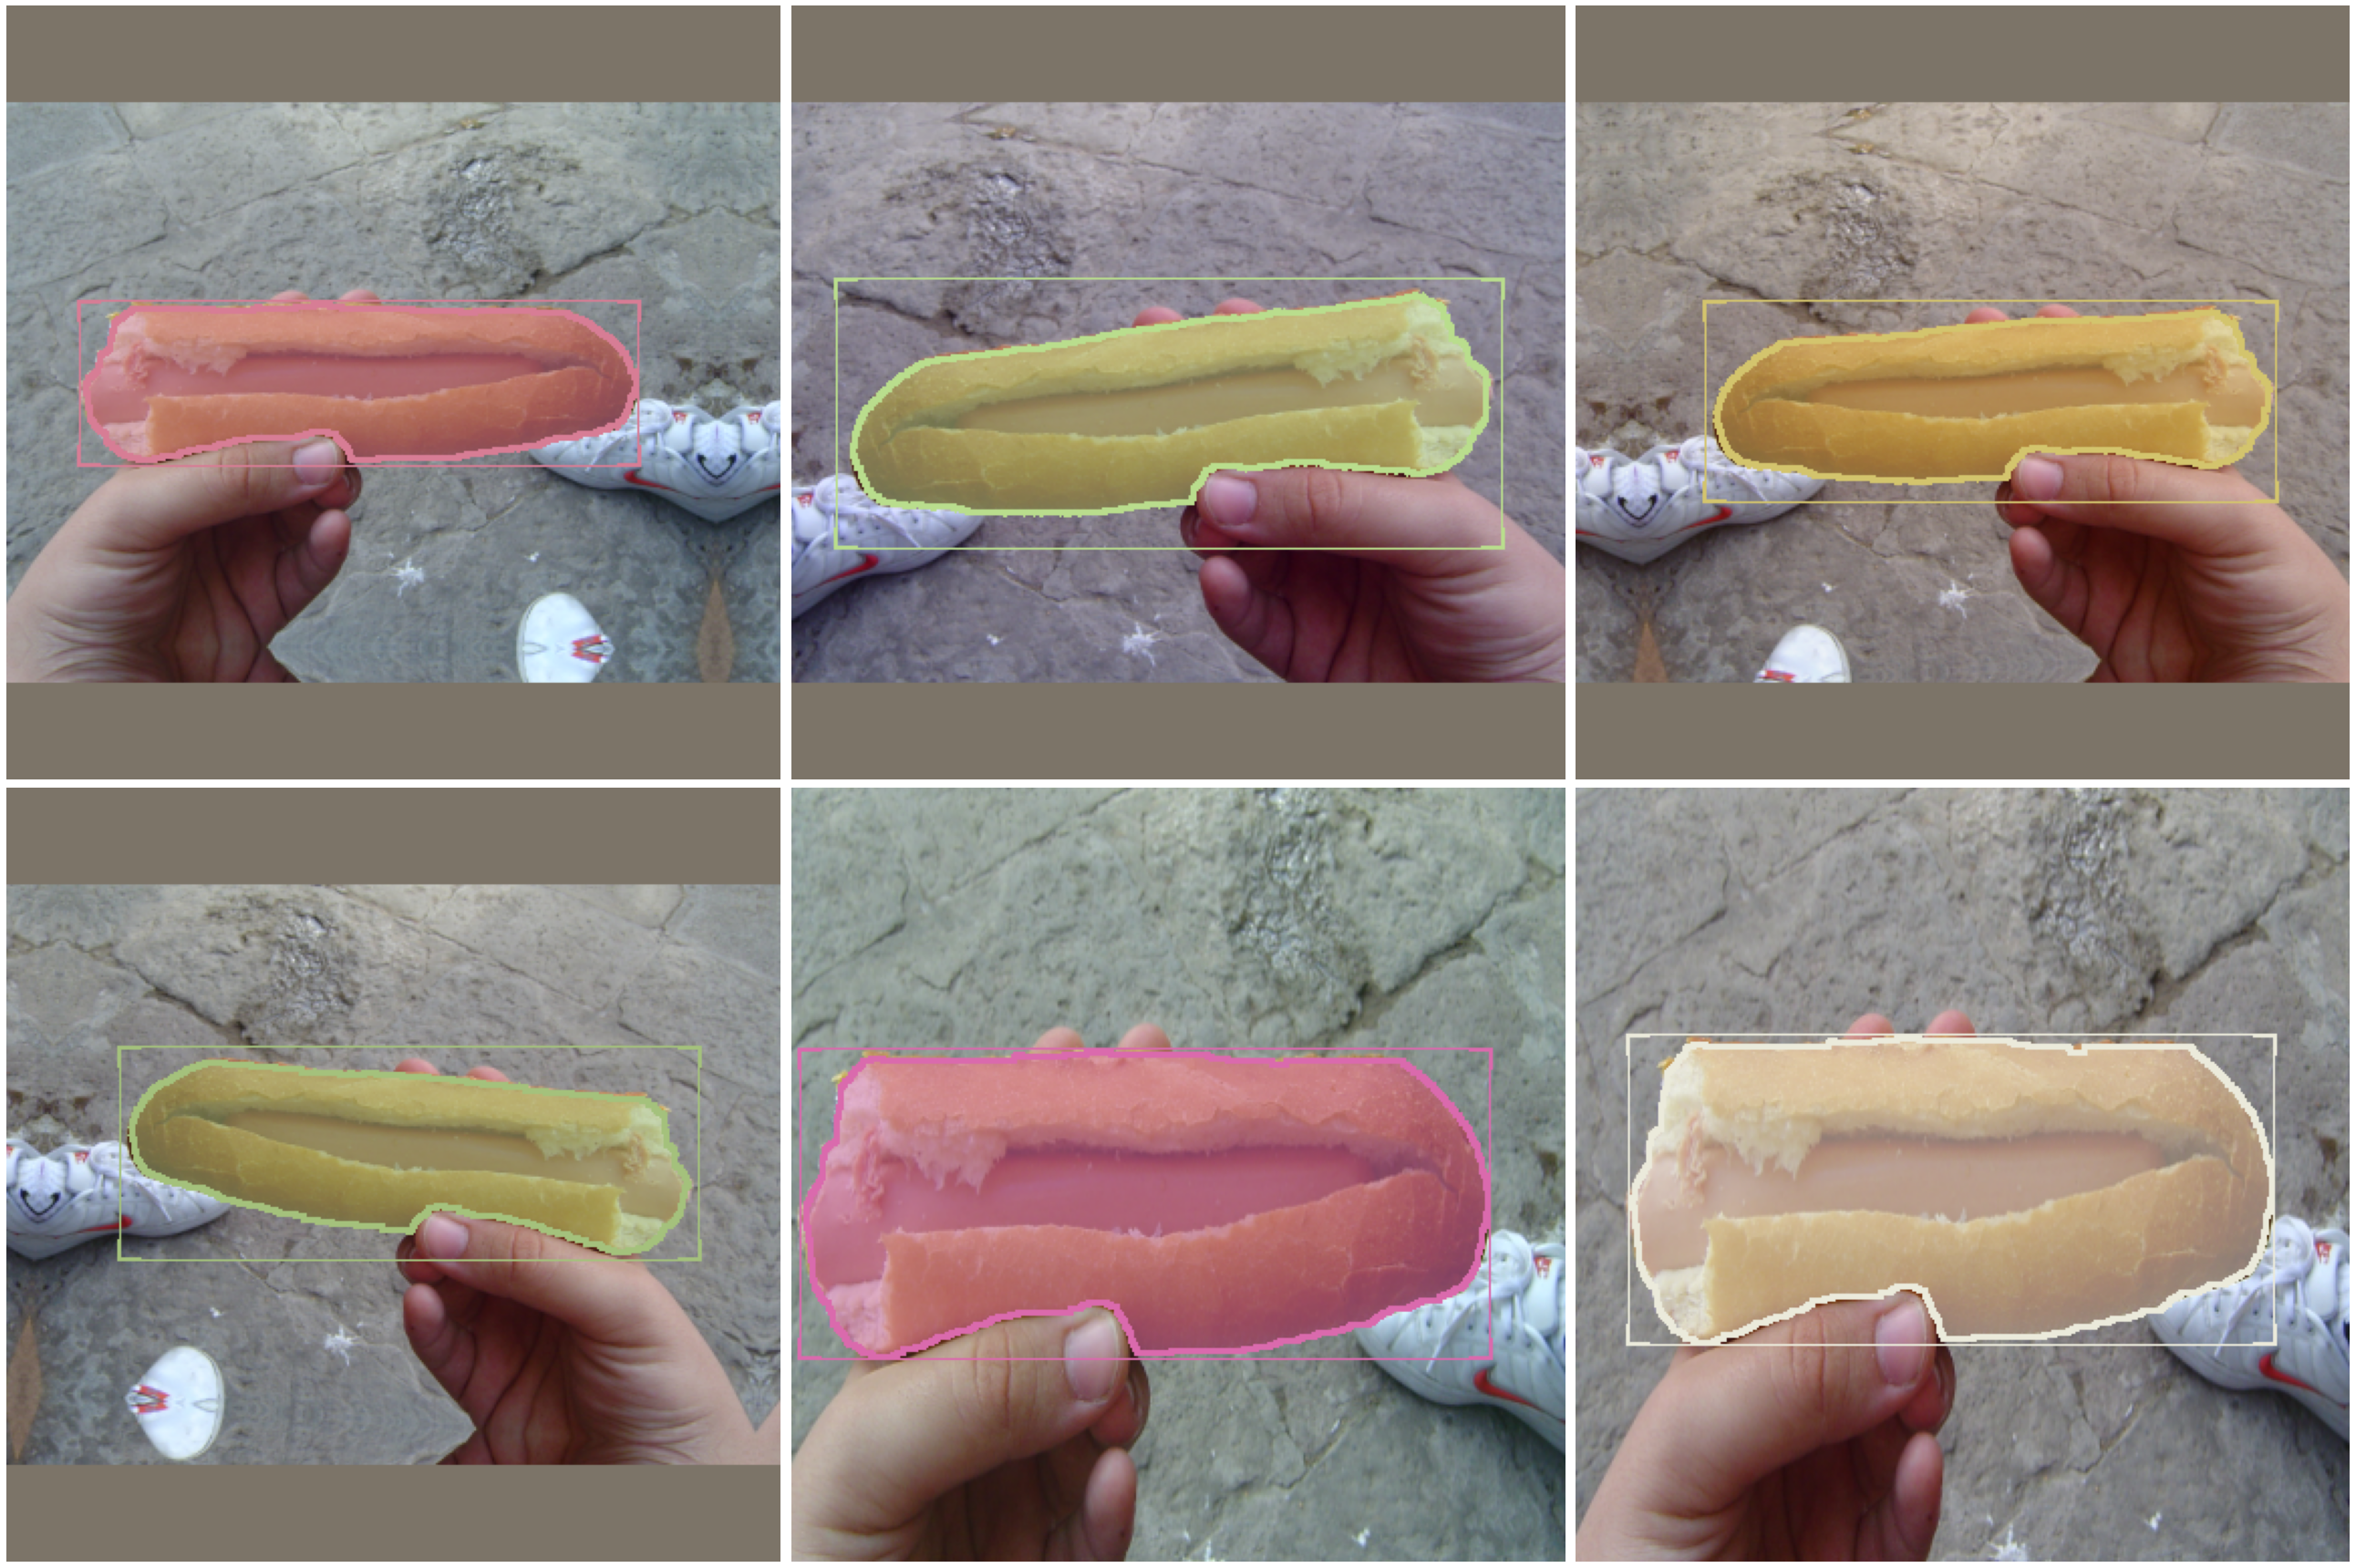

In [39]:
# Transforms
shift_scale_rotate = tfms.A.ShiftScaleRotate(rotate_limit=10)
crop_fn = partial(tfms.A.RandomSizedBBoxSafeCrop, p=0.5)
train_tfms = tfms.A.Adapter(
    [
        *tfms.A.aug_tfms(
            size=image_size, 
            presize=presize,
            shift_scale_rotate=shift_scale_rotate,
            crop_fn=crop_fn,
        ), 
        tfms.A.Normalize()
    ]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

# Shows how the transforms affects a single sample
samples = [train_ds[0] for _ in range(6)]
show_samples(
    samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True
)

### Define model object

In [40]:
# mask rcnn
model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet50_fpn()
metrics = [COCOMetric(metric_type=COCOMetricType.mask)] # error with torchvision and fastai

# faster rcnn
# model_type = models.torchvision.faster_rcnn
# backbone = model_type.backbones.resnet50_fpn
# metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [41]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map))

### Create DataLoaders

In [42]:
train_dl = model_type.train_dl(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_dl = model_type.valid_dl(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

### Training

In [63]:
fastai_learner = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)
if torch.cuda.device_count() > 1: fastai_learner.to_parallel()

In [64]:
fastai_learner.fine_tune(epochs, lr, freeze_epochs=2)

### Test on a subset from the validation data

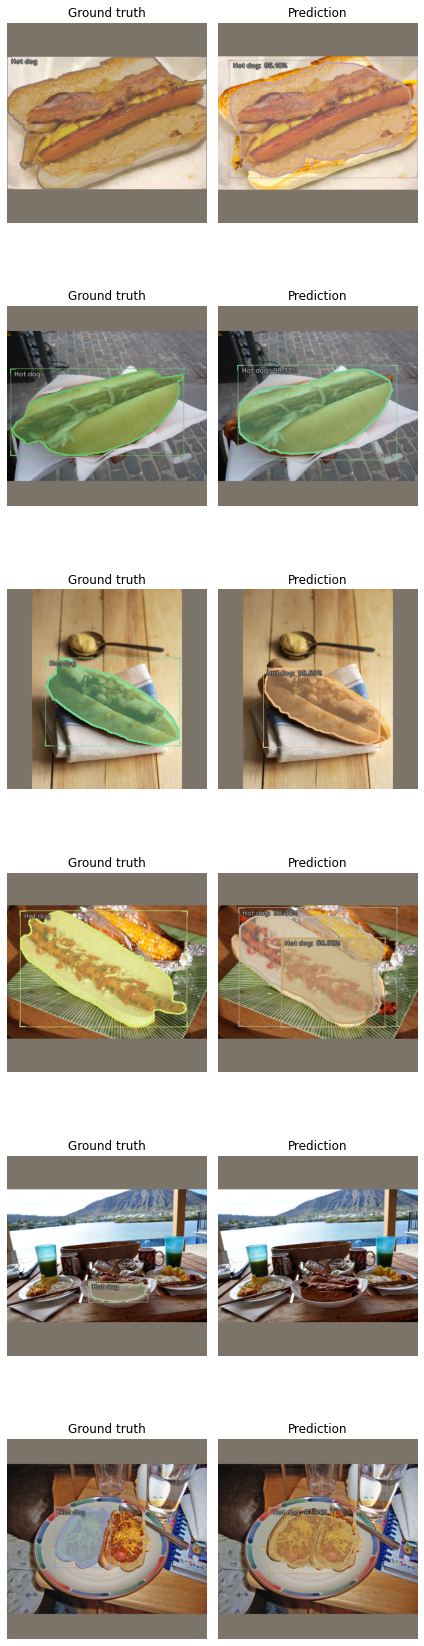

In [65]:
samples = [valid_ds[i] for i in range(6)]
preds = model_type.predict(model=model, dataset=samples)
show_preds(preds=preds, denormalize_fn=denormalize_imagenet)

### Save model weights to disk

In [67]:
model_dir='./model_store'
list_of_labels = [selected_label]

In [69]:
save_dir = Path(model_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# eager mode - recommended from http://pytorch.org/docs/master/notes/serialization.html
with open(save_dir/'model.pth', 'wb') as f:
    torch.save(model.state_dict(), f)

# save list of classes, ordered by index!
if not isinstance(list_of_labels,list): list_of_labels = [list_of_labels]
with open(save_dir/'labels.txt', 'w') as f:
    for c in list_of_labels:
        f.write(f"{c}\n")

# scripted model - https://discuss.pytorch.org/t/torch-jit-trace-is-not-working-with-mask-rcnn/83244/8
with torch.no_grad():
    scripted_model = torch.jit.script(model.eval())
scripted_model.save(save_dir/'jit-model.pt')

## Load custom model & run inference on a single image

In [1]:
from icevision.all import *

### Load saved model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
use_label = 'choripan'
model_path = './model_store/model.pth'

In [3]:
class_map = ClassMap([use_label])

In [4]:
# mask rcnn
model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet50_fpn

# faster rcnn
# model_type = models.torchvision.faster_rcnn
# backbone = model_type.backbones.resnet50_fpn

In [5]:
# load weights in eager mode
infer_model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map))
state_dict = torch.load(model_path, map_location=device)
infer_model.load_state_dict(state_dict)

<All keys matched successfully>

### Download sample image

In [6]:
import requests

In [15]:
def _download_image(image_url):
    res = requests.get(image_url, stream=True)
    img = PIL.Image.open(res.raw)
    return np.array(img)

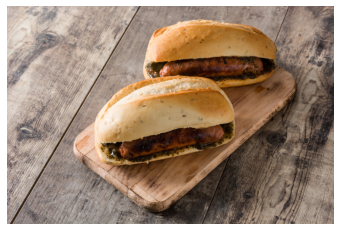

In [16]:
image_url = "https://i2.wp.com/www.buenossaborespanama.com/wp-content/uploads/2021/08/choripan-traditional-argentina-sandwich-with-chorizo-and-chimichurri-sauce-on-wooden-table-scaled.jpg?fit=2560%2C1707&ssl=1"
img = _download_image(image_url)
show_img(img);

### Pre-process image, run inference, and view results

In [9]:
image_size = 384
image_array = [img]

In [10]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])
infer_ds = Dataset.from_images(image_array, infer_tfms, class_map=class_map)

In [11]:
preds = model_type.predict(model=infer_model, dataset=infer_ds, detection_threshold=0.6)

/home/studio-lab-user/.conda/envs/machinelearnear-icevision-openimages/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


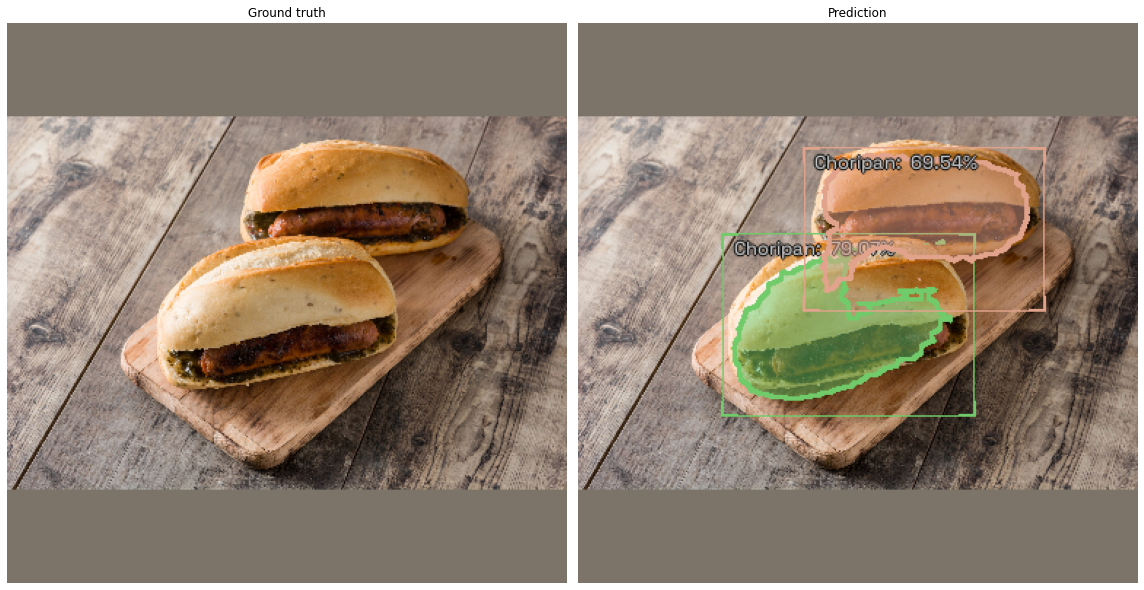

In [12]:
show_preds(preds=preds,show=True,figsize=(16,16))

### View results without IceVision
Modified from:
- https://github.com/lufficc/Vizer

In [24]:
from torchvision import transforms
from PIL import Image, ImageOps, ImageDraw, ImageFont

try:
    FONT = ImageFont.truetype('arial.ttf', 24)
except IOError:
    FONT = ImageFont.load_default()
    
palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)

In [25]:
def compute_color_for_labels(label):
    """
    Simple function that adds fixed color depending on the class
    """
    color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)

def _draw_single_box(image, xmin, ymin, xmax, ymax, color=(0, 255, 0), display_str=None, font=None, width=2, alpha=0.5, fill=False):
    if font is None:
        font = FONT

    draw = ImageDraw.Draw(image, mode='RGBA')
    left, right, top, bottom = xmin, xmax, ymin, ymax
    alpha_color = color + (int(255 * alpha),)
    draw.rectangle([(left, top), (right, bottom)], outline=color, fill=alpha_color if fill else None, width=width)

    if display_str:
        text_bottom = bottom
        # Reverse list and print from bottom to top.
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle(
            xy=[(left + width, text_bottom - text_height - 2 * margin - width),
                (left + text_width + width, text_bottom - width)],
            fill=alpha_color)
        draw.text((left + margin + width, text_bottom - text_height - margin - width),
                  display_str,
                  fill='black',
                  font=font)

    return image

def draw_boxes(image,
               boxes,
               labels=None,
               scores=None,
               class_name_map=None,
               width=2,
               alpha=0.5,
               fill=False,
               font=None,
               score_format=':{:.2f}'):
    """Draw bboxes(labels, scores) on image
    Args:
        image: numpy array image, shape should be (height, width, channel)
        boxes: bboxes, shape should be (N, 4), and each row is (xmin, ymin, xmax, ymax)
        labels: labels, shape: (N, )
        scores: label scores, shape: (N, )
        class_name_map: list or dict, map class id to class name for visualization.
        width: box width
        alpha: text background alpha
        fill: fill box or not
        font: text font
        score_format: score format
    Returns:
        An image with information drawn on it.
    """
    boxes = np.array(boxes)
    num_boxes = boxes.shape[0]
    if isinstance(image, Image.Image):
        draw_image = image
    elif isinstance(image, np.ndarray):
        draw_image = Image.fromarray(image)
    else:
        raise AttributeError('Unsupported images type {}'.format(type(image)))

    for i in range(num_boxes):
        display_str = ''
        color = (0, 255, 0)
        if labels is not None:
            this_class = labels[i]
            color = compute_color_for_labels(this_class)
            class_name = class_name_map[this_class] if class_name_map is not None else str(this_class)
            display_str = class_name

        if scores is not None:
            prob = scores[i]
            if display_str:
                display_str += score_format.format(prob)
            else:
                display_str += 'score' + score_format.format(prob)

        draw_image = _draw_single_box(image=draw_image,
                                      xmin=boxes[i, 0],
                                      ymin=boxes[i, 1],
                                      xmax=boxes[i, 2],
                                      ymax=boxes[i, 3],
                                      color=color,
                                      display_str=display_str,
                                      font=font,
                                      width=width,
                                      alpha=alpha,
                                      fill=fill)

    image = np.array(draw_image, dtype=np.uint8)
    return image

In [29]:
def _run_single_image_inference(image, model, image_size=384, score_threshold=0.5):
    if not isinstance(image,PIL.Image.Image): image = PIL.Image.fromarray(image)
    image_tfms = transforms.Compose([
        transforms.Resize(image_size), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])
    image_tensor = image_tfms(image).to(device)
    
    with torch.no_grad():
        out = model.to(device).eval()([image_tensor])[0]
        
    boxes, masks, labels, scores = out['boxes'], out['masks'], out['labels'], out['scores']
    indices = scores > score_threshold
    
    hpercent = (image_size/float(image.size[1]))
    wsize = int((float(image.size[0])*float(hpercent)))
    image = ImageOps.contain(image, (wsize, image_size))
    
    return boxes[indices].cpu(),masks[indices].cpu(), labels[indices].cpu(), scores[indices].cpu(), image

def _run_inference_and_plot_boxes(image, model, image_size=384, score_threshold=0.5, use_label='choripan'):
    boxes, masks, labels, scores, PIL_image = _run_single_image_inference(
        image, model, image_size=image_size, score_threshold=score_threshold)
    
    return Image.fromarray(draw_boxes(PIL_image, boxes, labels, scores, class_name_map=use_label))

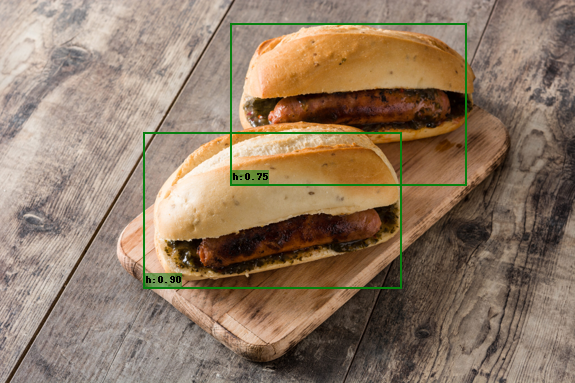

In [33]:
out_img = _run_inference_and_plot_boxes(img, infer_model, image_size=384, score_threshold=0.7, use_label='choripan')
out_img